In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import random


In [8]:
# Load data
train_set = pd.read_csv("train_cleandata.csv")
test_set = pd.read_csv("test_cleandata.csv")

# Convert categorical variables to categorical dtype
categorical_cols = ["quarter", "day", "team", "department"]
train_set[categorical_cols] = train_set[categorical_cols].astype("category")
test_set[categorical_cols] = test_set[categorical_cols].astype("category")

# Define predictors
department_predictors = [
    "targeted_productivity", "smv", "over_time", "incentive",
    "idle_time", "idle_men", "no_of_workers", "team"
]

department_predictors_finishing = [
       "targeted_productivity", "smv", "over_time", "no_of_workers", "team"
]

overall_predictors = department_predictors + ["department"]

In [24]:
# Configuration
DEPARTMENTS = {
    "Sewing": department_predictors,
    "Finishing": department_predictors_finishing,
    "Overall": overall_predictors
}

OUTLIER_METHODS = {
    "isolation_forest": IsolationForest(contamination=0.1, random_state=42),
    "none": None
}

def prepare_data(train, test, predictors, outlier_method):
    """Preprocess data with specified outlier handling"""
    # Detect and remove outliers
    train_clean = detect_outliers(train, outlier_method)
    test_clean = detect_outliers(test, outlier_method)
    
    # Separate features and target
    X_train = train_clean[predictors]
    X_test = test_clean[predictors]
    y_train = train_clean["actual_productivity"]
    y_test = test_clean["actual_productivity"]
    
    return X_train, X_test, y_train, y_test

def detect_outliers(data, method):
    """Detect outliers using specified method"""
    if method == "none":
        return data
    
    detector = OUTLIER_METHODS[method]
    numeric_cols = data.select_dtypes(include=np.number).columns
    detector.fit(data[numeric_cols])
    inliers = detector.predict(data[numeric_cols]) == 1
    return data[inliers]

# Ridge regression parameters
RIDGE_PARAMS = {
    'ridge__alpha': np.logspace(-3, 3, 100),  # Regularization strength
    'ridge__fit_intercept': [True, False],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

def train_ridge_model(X_train, y_train):
    """Ridge regression parameter tuning"""
    # Create preprocessing and model pipeline
    ridge_pipe = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('cat', OneHotEncoder(handle_unknown='ignore'), 
             X_train.select_dtypes(include=['category']).columns),
            ('num', StandardScaler(), 
             X_train.select_dtypes(include=np.number).columns)
        ])),
        ('ridge', Ridge(random_state=42))
    ])
    
    search = RandomizedSearchCV(
        ridge_pipe, 
        RIDGE_PARAMS,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        error_score='raise'
    )
    
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def run_analysis(department, outlier_method):
    """Updated analysis pipeline for Ridge Regression"""
    # Get appropriate data
    if department == "Overall":
        train = train_set
        test = test_set
    else:
        train = train_set[train_set["department"] == department.lower()]
        test = test_set[test_set["department"] == department.lower()]
    
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(
        train, test, DEPARTMENTS[department], outlier_method
    )
    
    # Train model
    best_model, best_params = train_ridge_model(X_train, y_train)
    
    # Evaluate
    metrics = {
        "train_mse": mean_squared_error(y_train, best_model.predict(X_train)),
        "test_mse": mean_squared_error(y_test, best_model.predict(X_test)),
        "train_r2": r2_score(y_train, best_model.predict(X_train)),
        "test_r2": r2_score(y_test, best_model.predict(X_test)),
        "best_params": best_params
    }
    
    # Coefficient visualization
    preprocessor = best_model.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()
    coefficients = pd.Series(best_model.named_steps['ridge'].coef_, index=feature_names)
    
    plt.figure(figsize=(10, 6))
    coefficients.sort_values().plot(kind='barh', color='steelblue')
    plt.title(f'{department} - Feature Coefficients (Ridge)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.savefig(f"{department} - Feature Coefficients (Ridge).png") 
    plt.show()

    return {
        "department": department,
        "outlier_method": outlier_method,
        **metrics
    }

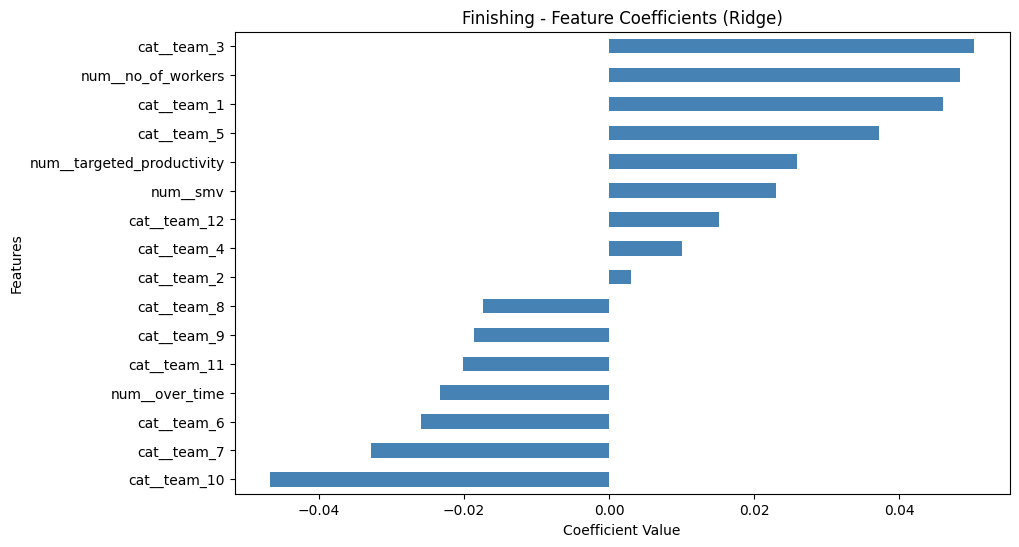

In [14]:
random.seed(42)
Finishing_results = run_analysis("Finishing", "isolation_forest")


In [15]:
Finishing_results

{'department': 'Finishing',
 'outlier_method': 'isolation_forest',
 'train_mse': 0.029303324572583864,
 'test_mse': 0.0256789831236926,
 'train_r2': 0.18690478919125264,
 'test_r2': 0.18099837094056515,
 'best_params': {'ridge__solver': 'auto',
  'ridge__fit_intercept': True,
  'ridge__alpha': np.float64(23.10129700083158)}}

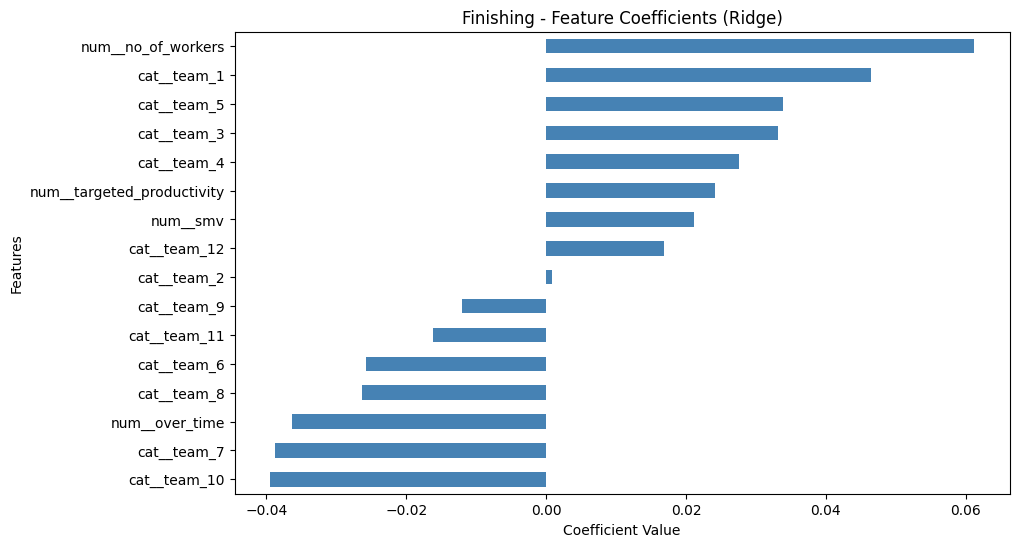

In [16]:
random.seed(42)
Finishing_results_with_outliers = run_analysis("Finishing", "none")

In [17]:
Finishing_results_with_outliers

{'department': 'Finishing',
 'outlier_method': 'none',
 'train_mse': 0.03149032079985163,
 'test_mse': 0.031123115681471032,
 'train_r2': 0.18502156755406163,
 'test_r2': 0.11069873367181426,
 'best_params': {'ridge__solver': 'lsqr',
  'ridge__fit_intercept': True,
  'ridge__alpha': np.float64(26.560877829466893)}}

In [19]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configuration
DEPARTMENTS = {
    "Sewing": department_predictors,
    "Finishing": department_predictors_finishing,
    "Overall": overall_predictors
}

OUTLIER_METHODS = {
    "isolation_forest": IsolationForest(contamination=0.1, random_state=42),
    "none": None
}

# Lasso regression parameters
LASSO_PARAMS = {
    'lasso__alpha': np.logspace(-4, 0, 100),  # Regularization strength (smaller range for Lasso)
    'lasso__fit_intercept': [True, False],
    'lasso__selection': ['cyclic', 'random']  # Lasso-specific parameter
}

def train_lasso_model(X_train, y_train):
    """Lasso regression parameter tuning"""
    # Create preprocessing and model pipeline
    lasso_pipe = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('cat', OneHotEncoder(handle_unknown='ignore'), 
             X_train.select_dtypes(include=['category']).columns),
            ('num', StandardScaler(), 
             X_train.select_dtypes(include=np.number).columns)
        ])),
        ('lasso', Lasso(random_state=42))
    ])
    
    search = RandomizedSearchCV(
        lasso_pipe, 
        LASSO_PARAMS,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        error_score='raise'
    )
    
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def run_analysis(department, outlier_method):
    """Updated analysis pipeline for Lasso Regression"""
    # Get appropriate data
    if department == "Overall":
        train = train_set
        test = test_set
    else:
        train = train_set[train_set["department"] == department.lower()]
        test = test_set[test_set["department"] == department.lower()]
    
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(
        train, test, DEPARTMENTS[department], outlier_method
    )
    
    # Train model
    best_model, best_params = train_lasso_model(X_train, y_train)
    
    # Evaluate
    metrics = {
        "train_mse": mean_squared_error(y_train, best_model.predict(X_train)),
        "test_mse": mean_squared_error(y_test, best_model.predict(X_test)),
        "train_r2": r2_score(y_train, best_model.predict(X_train)),
        "test_r2": r2_score(y_test, best_model.predict(X_test)),
        "best_params": best_params
    }
    
    # Coefficient visualization
    preprocessor = best_model.named_steps['preprocessor']
    feature_names = preprocessor.get_feature_names_out()
    coefficients = pd.Series(best_model.named_steps['lasso'].coef_, index=feature_names)
    
    plt.figure(figsize=(10, 6))
    coefficients.sort_values().plot(kind='barh', color='steelblue')
    plt.title(f'{department} - Feature Coefficients (Lasso)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.show()
    
    return {
        "department": department,
        "outlier_method": outlier_method,
        **metrics
    }

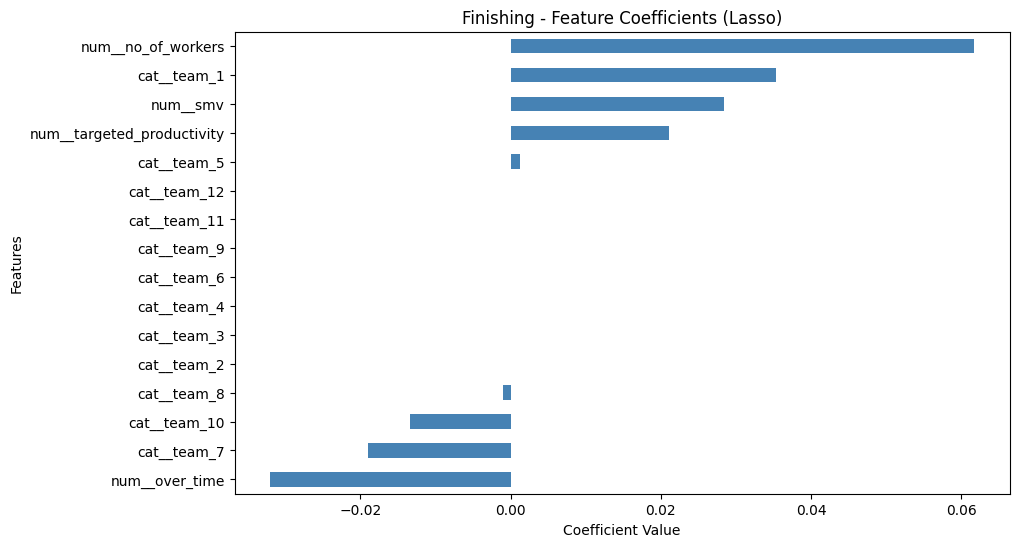

In [20]:
random.seed(42)
Finishing_results_with_outliers = run_analysis("Finishing", "none")

In [21]:
Finishing_results_with_outliers

{'department': 'Finishing',
 'outlier_method': 'none',
 'train_mse': 0.03281173116322778,
 'test_mse': 0.030504926307637993,
 'train_r2': 0.15082309261927507,
 'test_r2': 0.12836266547757635,
 'best_params': {'lasso__selection': 'random',
  'lasso__fit_intercept': True,
  'lasso__alpha': np.float64(0.0041320124001153384)}}

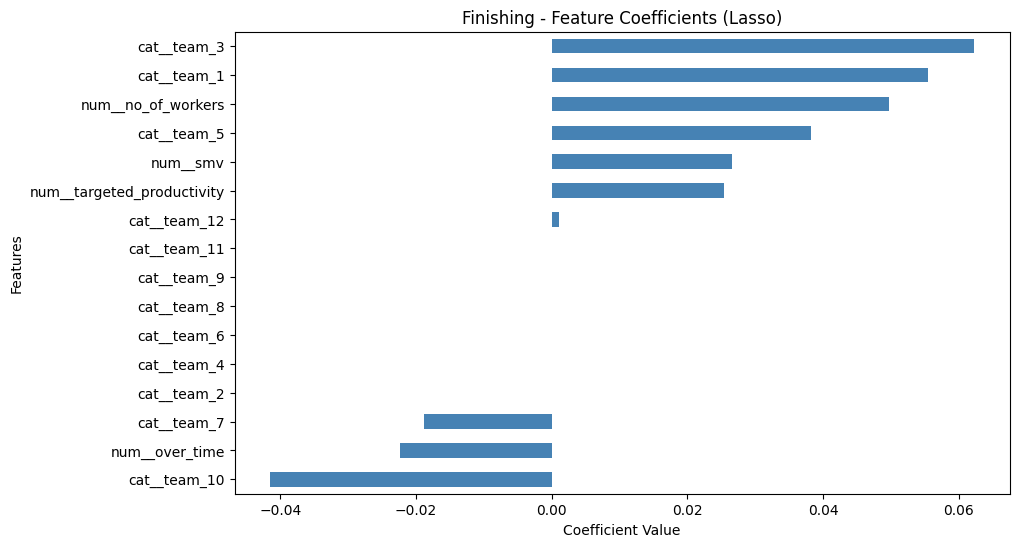

In [22]:
random.seed(42)
Finishing_results_with_outliers = run_analysis("Finishing", "isolation_forest")

In [23]:
Finishing_results_with_outliers

{'department': 'Finishing',
 'outlier_method': 'isolation_forest',
 'train_mse': 0.029611073447143157,
 'test_mse': 0.025931639465802573,
 'train_r2': 0.17836551456334715,
 'test_r2': 0.17294018753106133,
 'best_params': {'lasso__selection': 'random',
  'lasso__fit_intercept': True,
  'lasso__alpha': np.float64(0.002595024211399737)}}